# Logistic Regression

Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

It works very much the same way Linear Regression does, except that the optimization function is not OLS but [_maximum likelihood_](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation).

## Important considerations

- We use logistic regression to train a model to predict between 2-classes: Yes/No, Black/White, True/False. If we need to predict more than two classes, we need to build some artifacts in logistic regression that will be explained at the end of this notebook.
- No dependent variables should be among the set of features. Study the correlation between all the features separatedly.
- Scaled, norm'd and centered input variables.

The output from a logistic regression is always the log of the odds. We will explore this concept further along the exercise.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.pipeline import make_pipeline
from sklearn_pandas import DataFrameMapper

In [2]:
data = pd.read_csv('train_complete_prepared.csv')
data.head()

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LotFrontage
0,8,60,RL,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,Shed,350,11,2009,WD,Normal,200000,80.115468
1,51,60,RL,13869,Pave,NaN,IR2,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,7,2007,WD,Normal,177000,76.703758
2,112,80,RL,7750,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,4,2010,WD,Normal,180000,67.285313
3,148,60,RL,9505,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,NaN,NaN,NaN,0,5,2010,WD,Normal,222500,69.803112
4,178,50,RL,13650,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,7,2006,WD,Normal,172500,75.799522


Lets build a dataframe that will contain the type and number of NAs that each feature contains. We will use it to decide what variables to select. We will now from there what features are numerical and categorical, and how many contain NAs.

In [3]:
def dataframe_metainformation(df):
    meta = dict()
    descr = pd.DataFrame({'dtype': df.dtypes, 'NAs': df.isna().sum()})
    categorical_features = descr.loc[descr['dtype'] == 'object'].index.values.tolist()
    numerical_features = descr.loc[descr['dtype'] != 'object'].index.values.tolist()
    numerical_features_na = descr.loc[(descr['dtype'] != 'object') & (descr['NAs'] > 0)].index.values.tolist()
    categorical_features_na = descr.loc[(descr['dtype'] == 'object') & (descr['NAs'] > 0)].index.values.tolist()
    complete_features = descr.loc[descr['NAs'] == 0].index.values.tolist()
    meta['description'] = descr
    meta['categorical_features'] = categorical_features
    meta['categorical_features'] = categorical_features
    meta['categorical_features_na'] = categorical_features_na
    meta['numerical_features'] = numerical_features
    meta['numerical_features_na'] = numerical_features_na
    meta['complete_features'] = complete_features
    return meta

def print_metainformation(meta):
    print('Available types:', meta['description']['dtype'].unique())
    print('{} Features'.format(meta['description'].shape[0]))
    print('{} categorical features'.format(len(meta['categorical_features'])))
    print('{} numerical features'.format(len(meta['numerical_features'])))
    print('{} categorical features with NAs'.format(len(meta['categorical_features_na'])))
    print('{} numerical features with NAs'.format(len(meta['numerical_features_na'])))
    print('{} Complete features'.format(len(meta['complete_features'])))

meta = dataframe_metainformation(data)
print_metainformation(meta)

Available types: [dtype('int64') dtype('O') dtype('float64')]
80 Features
43 categorical features
37 numerical features
16 categorical features with NAs
0 numerical features with NAs
64 Complete features


Can we build a model that will predict the contents of one of those categorical columns with NAs? Let's try! I will start with `FireplaceQu` that presents a decent amount of NAs.

Define **target** and **features** to hold the variable we want to predict and the features I can use (those with no NAs). We remove the `Id` from the list of features to be used by our model. Finally, we establish what is the source dataset, by using only those rows from `data` that are not equal to NA.

Lastly, we will encode all categorical features (but the target) to have a proper setup for running the logistic regression. To encode, we'll use OneHotEncoding by calling `get_dummies`. The resulting dataset will have all numerical features.

In [4]:
target = 'FireplaceQu'
features = meta['complete_features']
features.remove('Id')
print('Selecting {} features'.format(len(features)))

data_complete = data.filter(features + [target])
data_complete = data_complete[data_complete[target].notnull()]

meta_complete = dataframe_metainformation(data_complete)
print_metainformation(meta_complete)
dummy_columns = meta_complete['categorical_features']
dummy_columns.remove(target)
data_encoded = pd.get_dummies(data_complete, columns=dummy_columns)
data_encoded.head(3)

Selecting 63 features
Available types: [dtype('int64') dtype('O') dtype('float64')]
64 Features
28 categorical features
36 numerical features
0 categorical features with NAs
0 numerical features with NAs
64 Complete features


,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,10382,7,6,1973,1973,240,859,32,216,...,0,0,0,0,1,0,0,0,1,0
2,80,7750,7,5,2000,2000,0,250,0,134,...,0,0,0,0,1,0,0,0,1,0
3,60,9505,7,5,2001,2001,180,0,0,884,...,0,0,0,0,1,0,0,0,1,0


How many occurences do we have from each class of the target variable?

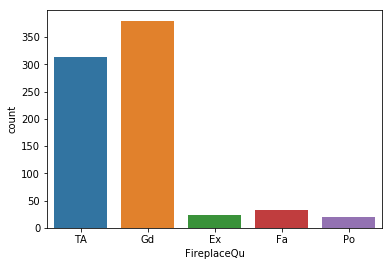

In [7]:
sns.countplot(x='FireplaceQu', data=data_encoded)

Since we've very few occurences of classes `Ex`, `Fa` and `Po`, we will remove them from the training set, and we will train our model to learn to classify only between `TA` or `Gd`.

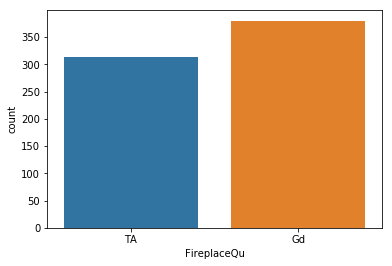

In [11]:
data_encoded = data_encoded[(data_encoded[target] != 'Ex') & (data_encoded[target] != 'Fa') & (data_encoded[target] != 'Po')]
sns.countplot(x='FireplaceQu', data=data_encoded);